# Spark DataFrame

* Last updated 20200923WED1800
    20191029_20170606_20170221_20161125

## S.1 학습내용

### S.1.1 목표

* Spark DataFrame을 생성하고, API를 사용할 수 있다.
* Spark SQL을 사용하여 데이터를 조회할 수 있다.
* Spark 데이터를 MongoDB에 쓰고, 읽을 수 있다.

### S.1.2 목차
* S.2 Jupyter Notebook에서 SparkSession 생성
* S.3 DataFrame
    * 특징
    * Schema
    * DataFrame의 API
* S.4 DataFrame 생성
* S.4.1 schema에서 생성하기
* S.4.2 RDD에서 생성하기
* S.4.3 Pandas
* S.4.4 csv 파일 읽기
* S.4.5 tsv 파일 읽기
* S.4.6 JSON 파일 읽기
* 문제: 월드컵 데이터 JSON
* S.4.7 Parquet 파일 읽기, 쓰기
* S.5 DataFrame API 사용해 보기
    * 컬럼 추가 withColumn, 컬럼 삭제 Drop
    * 사용자정의 함수 udf
    * 컬럼명 변경 withColumnRenamed
    * 그래프
    * 컬럼 조회 select
    * filter
    * regexp_replace 컬럼의 내용 변경
    * groupBy
    * partition
    * 통계 요약 describe
    * 결측값
* 문제: 년별 분기별 대여건수
* S.6 Spark SQL
* 문제 S-1: 네트워크에 불법적으로 침입하는 사용자의 분석
* 문제 S-2: Twitter JSON 데이터 읽기
* 문제 S-3: 뉴욕에서 출생한 신생아 분석
* 문제 S-4: 우버 택시의 운행기록 분석
* 문제 S-5: JDBC를 사용해서 데이터 읽기
* S.7 MongoDB Spark connector
* S.7.1 설정
* S.7.2 uri 
* S.7.3 MongoDB Python API 
* S.7.4 연습으로 쓰기, 읽기
* S.8 spark-submit
* S.8.1 간단한 작업
* S.8.2 MongoDB

## S.2 Jupyter Notebook에서 SparkSession 생성

### Spark를 설치한 경우

Spark를 설치했다면, Spark가 설치된 디렉토리를 SPARK_HOME으로 설정하고, 실행에 필요한 'py4j-0.10.1-src.zip', 'pyspark.zip' 라이브러리를 추가해야 한다.

In [2]:
import os
import sys
os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

그러나 pyspark만을 설치한 경우에는, 별도로 라이브러리를 추가하지 않아도 된다.
혹시 Python 2, 3 여러 버전이 설치된 경우에는 그 경로를 설정해 주어야 한다.

In [1]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [6]:
print (spark.version)

3.0.0


## S.3 DataFrame

### 특징

DataFrame은 **행, 열로 구조화**된 데이터구조이다.
관계형데이터베이스 RDB의 테이블이나 엑셀 쉬트sheet와 비슷하다.
또는 Pandas 또는 R을 사용해 보았다면 거기서 제공되는 DataFrame과 유사하다.
Apache Spark 1.0에서는 **SchemaRDD**라는 명칭으로 시험적으로 제공되었다. 이름에서 보듯이 RDD에 스키마를 얹어서 만든 개념이다.
그러나 Spark의 DataFrame은 **대용량 데이터를 처리하기 위해 만들어진 프레임워크로 분산**해서 사용할 수 있게 고안되었다.

앞서 사용했던 **RDD가 schema를 정하지 않는** 것과 달리, **DataFrame은 모델 schema**를 설정해서 사용을 한다. '열'에 대해 명칭 및 **데이터 타잎**을 가지고 있고, 이를 지켜서 데이터를 저장하게 된다. 

### Schema

**Row**는 DataFrame의 행으로, 데이터 요소항목을 묶어서 구성한다. **Python list나 dict**를 사용하여 Row를 구성할 수 있다.
**Column**은 DataFrame의 **열**이고, 다음과 같은 **데이터 타잎**을 가진다.

```python
- NullType
- StringType
- BinaryType
- BooleanType
- DateType
- TimestampType
- DoubleType
- DecimalType
- ShortType
- ArrayType
- MapType
```

### DataFrame의 API

RDD와 마찬가지로 DataFrame을 구성하여 **머신러닝**의 입력데이터로 사용할 수 있다.
현재 버전 2.0부터 RDD에 대한 지원은 줄여나가고, **버전 3.0 이후에는 DataFrame API를 공식적으로 지원**한다고 발표한 바 있다. RDD보다 우선적으로 사용하는 것이 좋겠다. 아래는 DataFrame에서 제공하는 일부 API이다.

기능 | 설명 | 예제
-------|-------|-------
```json``` | json 파일에서 읽기 | ```spark.read.json("employee.json")```
```show``` | DataFrame에 로딩된 데이터 읽기 | ```df.show()```
```schema``` | 데이터 schema 보기 | ```df.printSchema()```
```select``` | 열을 선택 | ```df.select("name")```
```filter``` | 조건으로 선택하여 읽기 | ```df.filter(dfs("age") > 23).show()```
```groupBy``` | 그룹으로 나누기 | ```df.groupBy("age").count().show()```
```dropna``` | na를 삭제 | ```df.dropna()``` ```df.na.drop()```
```fillna``` | na를 값으로 채우기 | ```fillna()```
```count``` | 행 세기 | ```df.count()```
```drop``` | 삭제 | ```df.drop("name")```


## S.4 DataFrame 생성

DataFrame은 관계형데이터베이스 RDB 테이블과 같이, schema를 정해서 생성한다.
**schema를 정해주지 않으면, Spark가 자동으로 유추**하게 된다.
RDD와 같이, 외부 파일 또는 배열과 같은 자료구조에서 읽어서 생성하고, 생성된 DataFrame은 분산하여 처리할 수 있게 된다.

생성 방법 | 설명 | 함수
----------|----------|----------
**외부**에서 읽기 | Hive, csv, JSON, RDB, XML, Parquet, Apache Cassandra, RDD 등 | **```spark.createDataFrame()```** 또는 **```spark.read()```**
**내부**에서 읽기 | Python list, dict 또는 ```pyspark.sql.Row``` 객체를 사용해서 한 줄씩 만들 수 있다. | **```spark.createDataFrame()```**

```createDataFrame()``` 함수는 RDD 또는 List와 같은 데이터에서 DataFrame을 생성한다.
반면에 ```spark.read()``` 함수는 csv, json과 같은 파일에서 데이터를 읽을 수 있고, 옵션을 설정해서 사용할 수 있다.

### S.4.1 schema 생성하기

DataFrame은 데이터 모델 schema를 정의하고, 각 컬럼의 명칭과 데이터타입을 정해야 한다.

#### 자동으로 인식하는 schema

우선 단순하게 Python 자료구조를 사용해서 생성해 본다.
아래 열이 3개인 데이터를 **```createDataFrame()```** 함수를 사용하여 넣어 보자.

In [3]:
myList=[('1','kim, js', 170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee', 170)]

In [4]:
myDf=spark.createDataFrame(myList)

이 경우 Spark가 **자동으로 schema를 설정**한다.
```printSchema()``` 함수로 schema를 출력해 보기로 하자.
* **컬럼**명은 **일련번호**를 가지고 생성된다. schema를 정하지 않았으므로, 열은 '_1', '_2'와 같이 명명된다.
* **데이터 타잎**도 유추해서 생성한다. 올바르게 되지 않을 경우도 있다는 점에 유의한다. 아래에서 보듯이 컬럼 1 학년은 ```String```, 컬럼 2 이름은 ```String```, 컬럼 3 키는 ```long```으로 인식하고 있다.
* nullable은 결측값이 허용되는지를 말하는 것이다. true이면 허용된다는 의미이다.

In [5]:
myDf.columns

['_1', '_2', '_3']

In [6]:
myDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



한 줄을 출력해 보자. 출력은 Row() 타입으로 앞서 정의한 schema와 일치하는 값을 포함하여 출력한다.
즉 첫째, 둘째는 문자열로 세째는 long 타입이다.

In [7]:
print (myDf.take(1))

[Row(_1='1', _2='kim, js', _3=170)]


#### 컬럼명 설정

앞서 컬럼 Column을 정의하지 않고 DataFrame을 생성하였는데, 이번에는 **컬럼을 정해서** 생성하자.
**```createDataFrame()```** 함수에 **인자로 컬럼명을 리스트 ```['year','name','height']```로** 정해준다.

In [8]:
cols = ['year','name','height']
_myDf = spark.createDataFrame(myList, cols)

In [9]:
_myDf.columns

['year', 'name', 'height']

그리고 한 줄 출력해 보면, 컬럼명이 변경되어 있다.

In [10]:
print (_myDf.take(1))

[Row(year='1', name='kim, js', height=170)]


데이터 100개를 생성해 보자.
우선 데이터의 원천이 되는 names, items를 정의하자.
여기서 하나씩 선택하여 데이터를 생성하게 된다.

In [14]:
names = ["kim","lee","lee","lim"]
items = ["espresso","latte","americano","affocato","long black","macciato"]

이 names, items 배열에서 **modulus**를 활용하여 하나씩 선택하여 데이터를 생성한다.
**names**는 4개이므로 4로 나눈 나머지와 **items**는 6개이므로 6으로 나눈 나머지를 하나씩 선택하고 있다.
그리고 컬럼명을 ```["name","coffee"]```으로 정한다.

In [15]:
coffeeDf = spark.createDataFrame([(names[i%4], items[i%6]) for i in range(100)],\
                           ["name","coffee"])

자동으로 생성된 schema가 데이터타입을 잘 집어내고 있다.
name, coffee 모두 string이다.

In [16]:
coffeeDf.printSchema()

root
 |-- name: string (nullable = true)
 |-- coffee: string (nullable = true)



In [17]:
coffeeDf.show(10)

+----+----------+
|name|    coffee|
+----+----------+
| kim|  espresso|
| lee|     latte|
| lee| americano|
| lim|  affocato|
| kim|long black|
| lee|  macciato|
| lee|  espresso|
| lim|     latte|
| kim| americano|
| lee|  affocato|
+----+----------+
only showing top 10 rows



#### Row 객체를 사용해서 생성

**Row**를 사용해 보자.
Row는 **이름(Column)이 붙여진 행**으로 **관계형데이터베이스 레코드 Record**와 같다. 
속성 명은 'year', 'name', 'height'로 명명한다.

In [18]:
from pyspark.sql import Row
Person = Row('year','name', 'height')
row1=Person('1','kim, js',170)

속성명을 읽을 때에는 **```row.key```** 또는 Python dict형식으로 **```row[key]```**와 같이 속성을 읽을 수 있다.

In [19]:
print ("row1: ", row1.year, row1.name, row1.height)

row1:  1 kim, js 170


위에서 설정한 Row를 사용하여 DataFrame을 만들어 보자.
**Python list에 Row를 넣어** 구성한다.
첫번째는 앞서 만든 row1 객체를 넣을 수 있다.

In [20]:
myRows = [row1,
          Person('1','lee, sm', 175),
          Person('2','lim, yg',180),
          Person('2','lee',170)]

In [21]:
myDf=spark.createDataFrame(myRows)

printSchema()를 해보면, **데이터 타잎**은 string, long으로 Spark에서 **자동** 인식되었다는 것을 알 수 있다.

In [22]:
print (myDf.printSchema())
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)

None
+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|    lee|   170|
+----+-------+------+



#### schema를 정의하고 생성

모델 schema를 정하고, **데이터 타잎**을 정의해 DataFrame을 생성해 본다.
**```StructType```**으로 구조체를 선언하고, 컬럼에 대해 **```StructField```**를 설정한다.
* **컬럼**의 명칭
* 앞서 소개했던 **데이터 타잎**
* 마지막은 **NULL**이 허용되는지 여부

```python
StructType([
    StructField(컬럼명, StringType(), True),
    ...
])
```

In [23]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType
mySchema=StructType([
    StructField("year", StringType(), True),
    StructField("name", StringType(), True),
    StructField("height", IntegerType(), True)
])

앞서 **myRows**를 데이터로, **mySchema**에서는 컬럼 명과 데이터타잎을 정의하여 ```createDataFrame()```함수의 인자로 넘겨주고 있다.

In [24]:
myDf=spark.createDataFrame(myRows, mySchema)

앞서 설정한 데이터타입으로 설정되어있다.

In [25]:
myDf.printSchema()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



In [26]:
myDf.take(1)

[Row(year='1', name='kim, js', height=170)]

### S.4.2 RDD에서 생성하기

RDD는 schema가 정해지지 않은 비구조적 데이터이다.
이와 같이 **schema를 정의하지 않으면, Spark는 schema를 유추**하게 된다.


#### schema 자동 인식

RDD로부터 DataFrame을 생성할 수 있다. 이 경우 schema를 설정하지 않으면 자동으로 인식된다.

In [9]:
myList=[('1','kim, js',170), ('1','lee, sm', 175), ('2','lim, yg',180), ('2','lee',170)]

In [10]:
myRdd = spark.sparkContext.parallelize(myList)

```toDF()```로 변환하거나 직접 ```createDataFrame()``` 함수를 사용하여 DataFrame을 생성할 수 있다.

In [11]:
rddDf=myRdd.toDF()

In [12]:
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



또는 RDD에서 DataFrame을 생성할 수 있다.

In [13]:
rddDf=spark.createDataFrame(myRdd)

In [14]:
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



#### Row를 사용

학년year는 앞에서는 **string**으로 인식되었다. 이번 예제에서는 **형변환**을 해 본다.
RDD의 ```map()``` 함수를 사용하여 각 속성을 읽고 ```int()``` 함수로 형변환을 한다.
각 속성에 명칭, year, name, height를 설정한다.

In [18]:
from pyspark.sql import Row
_myRdd=myRdd.map(lambda x:Row(year=int(x[0]), name=x[1], height=int(x[2])))

In [19]:
_myDf=spark.createDataFrame(_myRdd)

In [20]:
_myDf.printSchema()

root
 |-- year: long (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)



In [21]:
_myDf.take(1)

[Row(year=1, name='kim, js', height=170)]

```Row()```를 사용하여 RDD를 생성할 수도 있다.

In [89]:
from pyspark.sql import Row

r1=Row(name="js1", age=10)
r2=Row(name="js2", age=20)
_myRdd=spark.sparkContext.parallelize([r1,r2])

In [38]:
_myRdd.collect()

[Row(name='js1', age=10), Row(name='js2', age=20)]

####  schema를 정의하고 생성

앞서 보았듯이, schema를 정의하고 RDD에서 DataFrame을 생성할 수 있다.
**```StructType```**을 선언하고,
컬럼에 대해 **```StructField```**를 **컬럼명**, **데이터 타잎**, **NULL**이 허용되는지 여부를 설정한다.
과거 버전에서는 컬럼명이 정렬되면서 age, name 순서가 변경되었다.
현재는 **컬럼명을 정렬하지 않으므로, 순서대로** 아래와 같이 생성하면 된다.

In [39]:
schema=StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    #StructField("created", TimestampType(), True)
])
_myDf=spark.createDataFrame(_myRdd, schema)

In [40]:
_myDf.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)



In [41]:
_myDf.show()

+----+---+
|name|age|
+----+---+
| js1| 10|
| js2| 20|
+----+---+



schema를 정해서 RDD로부터 DataFrame을 생성할 수 있다.

In [42]:
from pyspark.sql.types import *

myRdd=spark.sparkContext.parallelize([(1, 'kim', 50.0), (2, 'lee', 60.0), (3, 'park', 70.0)])
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("height", DoubleType(), True)
])
_myDf = spark.createDataFrame(myRdd, schema)

In [43]:
_myDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: double (nullable = true)



In [44]:
_myDf.show()

+---+----+------+
| id|name|height|
+---+----+------+
|  1| kim|  50.0|
|  2| lee|  60.0|
|  3|park|  70.0|
+---+----+------+



## S.4.3 Pandas

Spark Dataframe은 다른 프로그래밍 언어에서도 분석도구로 많이 사용되는 형식이다.
엑셀 스프레드쉬트와 비슷하다. 또한 최근 많이 사용되는 **R**의 Dataframe이나 **Python Pandas**를 예로 들 수 있다.
Spark와 Pandas의 Dataframe을 비교하면,
**Pandas**는 데이터 양이 적은 경우, Spark는 분산처리할 수 있으므로 빅데이터에 보다 적합하다.
API를 사용하게 되면 Spark Dataframe과 Pandas 간에는 차이가 있다.

구분 | DataFrame | Pandas
-------|-------|-------
csv 파일 읽기 | read.json() | read_csv()
데이터타입 | inferschema=True 설정하면 추정 | 모두 strings

### Dataframe을 Pandas로 변환

Spark Dataframe을 ```toPandas()``` 함수를 사용하여 **Pandas로 변환**할 수 있다.

In [22]:
myDf.toPandas()

,_1,_2,_3
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170


### Pandas에서 csv 쓰기

Dataframe을 **csv**파일로 내보내고 Pandas로 읽어보자.

Dataframe을 csv로 쓰려면 라이브러리 ```com.databricks.spark.csv```를 사용해야 한다. **파일이 아니라 디렉토리가 생성**되고 그 안에 파일로 쓰여지게 된다. Pandas를 사용하면 우리가 보통 사용하는 하나의 파일로 쓰여진다.

한 번 생성이 되면 덮어쓰기를 하지 않기 때문에, 다시 write() 할 경우에는 이전 디렉토리를 삭제하도록 하자.

In [89]:
myDf.write.format('com.databricks.spark.csv').save(os.path.join('data','_myDf.csv'))

In [90]:
!ls -l data/_myDf.csv/

total 4
-rw-r--r-- 1 jsl jsl 58  9월 16 15:56 part-00000-2627fdd4-7668-4ee9-840c-9e84fdadb86a-c000.csv
-rw-r--r-- 1 jsl jsl  0  9월 16 15:56 _SUCCESS


Pandas를 이용하여 Dataframe을 csv파일로 내보낼 수 있다.

```python
,year,name,height
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170
```

In [36]:
myDf.toPandas().to_csv(os.path.join('data','myDf.csv'))

Pandas에서 컬럼을 생성,삭제 해보자.
recode - 현재 변수 값을 다시 줄 경우

나라변 국제전화코드는 Japan: 81, South Korea: 82, Hong Kong: 852, Australia: 61을 사용한다

In [47]:
import pandas as pd
icc = pd.DataFrame( { 'country': ['South Korea','Japan','Hong Kong'],'codes': [81, 82, 852] })

In [48]:
icc

,country,codes
0,South Korea,81
1,Japan,82
2,Hong Kong,852


전화코드가 81인 경우 출력해보자.

In [50]:
icc[icc['codes']==81]

,country,codes
0,South Korea,81


### S.4.4 csv 파일에서 생성

#### RDD에서 DataFrame

앞서 RDD에서 읽었던 csv파일을 다시 읽어보자.

```sparkContext.textFile()``` 함수로 읽은 파일은 RDD이다.

In [23]:
from pyspark.sql import Row
cfile= os.path.join("data", "ds_spark_2cols.csv")
lines = spark.sparkContext.textFile(cfile)

RDD에서 ```Row()```를 사용하여 Dataframe으로 변환한다.

In [24]:
_col12 = lines.map(lambda l: l.split(","))
col12 = _col12.map(lambda p: Row(col1=int(p[0].strip()), col2=int(p[1].strip())))

_myDf = spark.createDataFrame(col12)

In [25]:
_myDf.printSchema()
_myDf.collect()

root
 |-- col1: long (nullable = true)
 |-- col2: long (nullable = true)



[Row(col1=35, col2=2),
 Row(col1=40, col2=27),
 Row(col1=12, col2=38),
 Row(col1=15, col2=31),
 Row(col1=21, col2=1),
 Row(col1=14, col2=19),
 Row(col1=46, col2=1),
 Row(col1=10, col2=34),
 Row(col1=28, col2=3),
 Row(col1=48, col2=1),
 Row(col1=16, col2=2),
 Row(col1=30, col2=3),
 Row(col1=32, col2=2),
 Row(col1=48, col2=1),
 Row(col1=31, col2=2),
 Row(col1=22, col2=1),
 Row(col1=12, col2=3),
 Row(col1=39, col2=29),
 Row(col1=19, col2=37),
 Row(col1=25, col2=2)]

#### DataFrame으로 직접 읽기

format().load() 또는 csv() 함수로 csv 파일을 읽어서 DataFrame을 만들 수 있다.

In [28]:
%%writefile data/ds_spark.csv
1,2,3,4
11,22,33,44
111,222,333,444

Overwriting data/ds_spark.csv


#### format load

csv 패키지를 사용해서 읽어 본다. 우선 [Spark의 csv 패키지를 추가한다.](https://spark-packages.org/package/databricks/spark-csv) 패키지는 설정파일 ```spark-defaults.conf```에 추가할 수 있다.

```python
$ vim conf/spark-defaults.conf
spark.jars.packages=com.databricks:spark-csv_2.11:1.5.0
```

```format("csv").load("path")```이라고 하고, options() 설정을 미리 넣을 수 있다.

In [94]:
df = spark\
        .read\
        .format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true', delimiter=',')\
        .load(os.path.join('data','ds_spark.csv'))

In [95]:
df.show()

+---+---+---+---+
|  1|  2|  3|  4|
+---+---+---+---+
| 11| 22| 33| 44|
|111|222|333|444|
+---+---+---+---+



In [96]:
df.printSchema()

root
 |-- 1: integer (nullable = true)
 |-- 2: integer (nullable = true)
 |-- 3: integer (nullable = true)
 |-- 4: integer (nullable = true)



inferschema를 제외하면, string으로 자동인식한다.

In [97]:
df = spark\
        .read\
        .format('com.databricks.spark.csv')\
        .options(header='true', delimiter=',')\
        .load(os.path.join('data','ds_spark.csv'))

In [98]:
df.printSchema()

root
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- 4: string (nullable = true)



#### csv

또는 
```csv("path")```로 직접 DataFrame으로 읽을 수 있다.

In [57]:
df = spark\
        .read\
        .options(header='true', inferschema='true', delimiter=',')\
        .csv(os.path.join('data', 'ds_spark.csv'))
df.show()

+---+---+---+---+
|  1|  2|  3|  4|
+---+---+---+---+
| 11| 22| 33| 44|
|111|222|333|444|
+---+---+---+---+



### S.4.5 tsv 파일 읽기

tsv (tab-separated values)는 **Tab으로 분리된 파일**을 말한다.
'\t'이 포함되어 있는 경우, 혹시 string으로 데이터타잎을 설정하기도 한다 (과거 Spark 버전에서)

TAB은 whitespace이므로 그냥 split()을 해도 된다.

In [21]:
import numpy as np
np.array([float(x) for x in '1.658985	4.285136'.split()])

array([1.658985, 4.285136])

URL로 가서 http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights
마우스로 긁어서 50행만 복사해 보자.

In [ ]:
# %load data/ds_spark_heightweight.txt
1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93

#### RDD

우선 RDD로 읽어보자.

In [58]:
from pyspark.sql.types import *
_tRdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

tsv는 '\t'로 분리해도 되고, split() 함수는 <TAB>을 포함한 whitespace로 분할하게 되므로 그냥 두어도 된다.

In [59]:
#tRdd=rdd.map(lambda x:x.split('\t'))
_tRddSplitted = _tRdd.map(lambda x:x.split())

#### 형변환

위 tsv 파일에서 생성한 RDD를 탭으로 분리하면서, ```float()```로 형변환을 해보자.

In [60]:
#import numpy as np
#myRdd=rdd.map(lambda line:np.array([float(x) for x in line.split('\t')]))
tRdd=_tRdd.map(lambda line:[float(x) for x in line.split('\t')])
tRdd.take(1)

[[1.0, 65.78, 112.99]]

#### schema 설정

schema를 **자동으로 설정하면, string**으로 읽혀진다.
schema를 설정한다고 해도, string -> integer, double로 형변환은 이루어지지 않는다.
string의 **형변환을 명시적**으로 해주어야 한다.

```python
mySchema = StructType([
    StructField("id", IntegerType(), True),
    StructField("weight", DoubleType(), True),
    StructField("height", DoubleType(), True)
])
myDf=spark.createDataFrame(myRdd, mySchema)
```

#### DataFrame 생성

위 tRdd로부터 컬럼명을 주어 DataFrame을 생성해보자.

In [61]:
tDfNamed = spark.createDataFrame(tRdd, ["id","weight","height"])

In [62]:
tDfNamed.printSchema()

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)



In [63]:
tDfNamed.take(1)

[Row(id=1.0, weight=65.78, height=112.99)]

### 컬럼을 split으로 분할

text() 함수를 이용해서 파일을 읽을 수 있다.

In [64]:
tDftxt = spark.read.text(os.path.join('data','ds_spark_heightweight.txt'))

<TAB>으로 분리되지 못해 전체를 변수명 value, 타입은 string으로 읽고 있어, 이를 분리해야 한다.

In [67]:
tDftxt.printSchema()

root
 |-- value: string (nullable = true)



pyspark.sql.functions은 함수이므로, import할 경우

* ```import pyspark.sql.functions.split``` 이렇게 하지 않고, 
* ```from pyspark.sql.functions import split``` 이렇게 한다.

In [65]:
from pyspark.sql.functions import split

split_col = split(tDftxt['value'], '\t')

In [ ]:
분리된 컬럼은 getItem() 함수로 가져와서 각 각 weight, height 컬럼이 된다.

In [68]:
split_col.getItem(1)

Column<b'split(value, \t, -1)[1]'>

In [71]:
tDftxt = tDftxt.withColumn('weight', split_col.getItem(1))
tDftxt = tDftxt.withColumn('height', split_col.getItem(2))

In [72]:
tDftxt.show()

+---------------+------+------+
|          value|weight|height|
+---------------+------+------+
| 1	65.78	112.99| 65.78|112.99|
| 2	71.52	136.49| 71.52|136.49|
| 3	69.40	153.03| 69.40|153.03|
| 4	68.22	142.34| 68.22|142.34|
| 5	67.79	144.30| 67.79|144.30|
| 6	68.70	123.30| 68.70|123.30|
| 7	69.80	141.49| 69.80|141.49|
| 8	70.01	136.46| 70.01|136.46|
| 9	67.90	112.37| 67.90|112.37|
|10	66.78	120.67| 66.78|120.67|
|11	66.49	127.45| 66.49|127.45|
|12	67.62	114.14| 67.62|114.14|
|13	68.30	125.61| 68.30|125.61|
|14	67.12	122.46| 67.12|122.46|
|15	68.28	116.09| 68.28|116.09|
|16	71.09	140.00| 71.09|140.00|
|17	66.46	129.50| 66.46|129.50|
|18	68.65	142.97| 68.65|142.97|
|19	71.23	137.90| 71.23|137.90|
|20	67.13	124.04| 67.13|124.04|
+---------------+------+------+
only showing top 20 rows



#### csv 함수로 tsv 읽기

In [73]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))
tDf.show()

+---+-----+------+
|_c0|  _c1|   _c2|
+---+-----+------+
|  1|65.78|112.99|
|  2|71.52|136.49|
|  3| 69.4|153.03|
|  4|68.22|142.34|
|  5|67.79| 144.3|
|  6| 68.7| 123.3|
|  7| 69.8|141.49|
|  8|70.01|136.46|
|  9| 67.9|112.37|
| 10|66.78|120.67|
| 11|66.49|127.45|
| 12|67.62|114.14|
| 13| 68.3|125.61|
| 14|67.12|122.46|
| 15|68.28|116.09|
| 16|71.09| 140.0|
| 17|66.46| 129.5|
| 18|68.65|142.97|
| 19|71.23| 137.9|
| 20|67.13|124.04|
+---+-----+------+
only showing top 20 rows



### S.4.6 JSON 파일에서 생성

#### JSON
JSON은 JavaScript Object Notation, 즉 자바스크립트에서 사용되는 표기법. 사람이 읽을 수 있는 텍스트로 표기하며, key-value 쌍으로 되어 있다.
현재 널리 쓰이고 있어 XML 대용으로 널리 쓰이고 있다.
Spark example 폴더에 있는 ```people.json``` JSON 파일이다.

```python
{"name":"Michael"}
{"name":"Andy", "age":30}
{"name":"Justin", "age":19}
```

### 트위터 데이터

트위터 데이터는 JSON 형식을 가지고 있다.
아래는 트윗 1개의 샘플이다.
실제 트윗 데이터를 구할 수 없다면 아래 샘플을 파일로 저장한 후 사용하면 된다.

```python
{"contributors": null, "truncated": false, "text": "RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fi…", "is_quote_status": false, "in_reply_to_status_id": null, "id": 801657325836763136, "favorite_count": 0, "entities": {"symbols": [], "user_mentions": [{"id": 17659206, "indices": [3, 10], "id_str": "17659206", "screen_name": "soompi", "name": "Soompi"}], "hashtags": [{"indices": [12, 22], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [100, 123], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "801657325836763136", "favorited": false, "retweeted_status": {"contributors": null, "truncated": false, "text": "#SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fifXHpF8or", "is_quote_status": false, "in_reply_to_status_id": null, "id": 800593781586132993, "favorite_count": 1649, "entities": {"symbols": [], "user_mentions": [], "hashtags": [{"indices": [0, 10], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [88, 111], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}], "media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"https://about.twitter.com/products/tweetdeck\" rel=\"nofollow\">TweetDeck</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "800593781586132993", "favorited": false, "user": {"follow_request_sent": false, "has_extended_profile": true, "profile_use_background_image": true, "default_profile_image": false, "id": 17659206, "profile_background_image_url_https": "https://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "verified": true, "translator_type": "none", "profile_text_color": "999999", "profile_image_url_https": "https://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "profile_sidebar_fill_color": "000000", "entities": {"url": {"urls": [{"url": "http://t.co/3evT80UlR9", "indices": [0, 22], "expanded_url": "http://www.soompi.com", "display_url": "soompi.com"}]}, "description": {"urls": []}}, "followers_count": 987867, "profile_sidebar_border_color": "000000", "id_str": "17659206", "profile_background_color": "1E1E1E", "listed_count": 3982, "is_translation_enabled": true, "utc_offset": -28800, "statuses_count": 80038, "description": "The original K-pop community. We take gifs, OTPs, and reporting on your bias' fashion choices seriously. But not rumors. Ain't nobody got time for that.", "friends_count": 3532, "location": "Worldwide", "profile_link_color": "31B6F4", "profile_image_url": "http://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "following": false, "geo_enabled": false, "profile_banner_url": "https://pbs.twimg.com/profile_banners/17659206/1478803767", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "screen_name": "soompi", "lang": "en", "profile_background_tile": true, "favourites_count": 1493, "name": "Soompi", "notifications": false, "url": "http://t.co/3evT80UlR9", "created_at": "Wed Nov 26 20:48:27 +0000 2008", "contributors_enabled": false, "time_zone": "Pacific Time (US & Canada)", "protected": false, "default_profile": false, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Mon Nov 21 06:56:46 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "extended_entities": {"media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "metadata": {"iso_language_code": "en", "result_type": "recent"}}, "user": {"follow_request_sent": false, "has_extended_profile": false, "profile_use_background_image": true, "default_profile_image": true, "id": 791090169818521600, "profile_background_image_url_https": null, "verified": false, "translator_type": "none", "profile_text_color": "333333", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "profile_sidebar_fill_color": "DDEEF6", "entities": {"description": {"urls": []}}, "followers_count": 0, "profile_sidebar_border_color": "C0DEED", "id_str": "791090169818521600", "profile_background_color": "F5F8FA", "listed_count": 0, "is_translation_enabled": false, "utc_offset": null, "statuses_count": 96, "description": "", "friends_count": 7, "location": "", "profile_link_color": "1DA1F2", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "following": false, "geo_enabled": false, "profile_background_image_url": null, "screen_name": "enriquesanq", "lang": "es", "profile_background_tile": false, "favourites_count": 161, "name": "Enrique santos", "notifications": false, "url": null, "created_at": "Wed Oct 26 01:32:49 +0000 2016", "contributors_enabled": false, "time_zone": null, "protected": false, "default_profile": true, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Thu Nov 24 05:22:55 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "metadata": {"iso_language_code": "en", "result_type": "recent"}}
```

#### 파일에서 트윗 읽기

그러나 JSON파일은 **JSON이 아니라 문자열**이다. 파일에서 읽은 후 **JSON으로 변환**을 해야 한다.
트윗은 '\n'으로 하나씩 구분되어 있고 ```readlines()``` 함수로 전체를 읽을 수 있다.

In [91]:
import os
_jfname=os.path.join('src','ds_twitter_seoul_3.json')
with open(_jfname, 'rb') as f:
    data = f.readlines()

In [122]:
import json
data_json_str = json.loads(data[0])

In [123]:
type(data_json_str)

dict

In [124]:
len(data_json_str)

26

#### pandas에서  트윗 읽기

In [125]:
type(data)

list

In [126]:
type(data[0])

bytes

위 Tweet데이터는 json형식이다. 따라서 list 구조로 만들어 주려면, 앞 뒤로 대괄호 ```[ ]```를 넣고, 각 tweet은 컴마로 연결한다.
```join()``` 함수는 인자를 구분자 ","로 병합한다.

```python
",".join(["A", "B", "C"]) # A,B,C
```

data는 bytes이고, 이를 join()하는 함수는 str을 대상으로 하기 때문에, 문자열에 ```b```를 붙여 bytes로 변환한 후 연결한다.


In [127]:
data_json_str = b"[" + b','.join(data) + b"]"

아직 JSON으로 변환이 되지 않았고, 문자열 전체 길이를 알아 보자. 파일의 크기를 알 수 있다.

In [128]:
len(data_json_str)

11310468

이제 Pandas로 읽어 보자. Pandas 라이브러리에서 제공하는 read_json()함수를 사용한다.

read_json()에 경로를 넘겨주어도 되지 않나??????

In [129]:
import pandas as pd

tweetPd = pd.read_json(data_json_str)

shape()은 행과 열의 갯수를 알려준다.

In [130]:
tweetPd.shape

(2013, 30)

count() 함수는 행의 갯수를 나타내는데, 숫자가 서로 다른 것은 비워있는 경우가 서로 다르기 때문이다.

In [131]:
print (tweetPd.count())

contributors                    0
truncated                    2013
text                         2013
is_quote_status              2013
in_reply_to_status_id         131
id                           2013
favorite_count               2013
entities                     2013
retweeted                    2013
coordinates                    55
source                       2013
in_reply_to_screen_name       153
in_reply_to_user_id           153
retweet_count                2013
id_str                       2013
favorited                    2013
retweeted_status             1304
user                         2013
geo                            55
in_reply_to_user_id_str       153
possibly_sensitive           1097
lang                         2013
created_at                   2013
in_reply_to_status_id_str     131
place                          65
metadata                     2013
extended_entities             506
quoted_status_id              133
quoted_status                  19
quoted_status_

컬럼 'id'를 10개만 읽어 보자.

In [132]:
tweetPd['id'][:10]

0    801657325836763136
1    801657325677400064
2    801657307637678080
3    801657305628430336
4    801657297449586688
5    801657287697895424
6    801657280760397824
7    801657276788523008
8    801657268177604608
9    801657258400616449
Name: id, dtype: int64

#### DataFrame에서 트윗 읽기


In [133]:
jfile= os.path.join('src','ds_twitter_seoul_3.json')

tweetDf= spark.read.json(jfile)

In [134]:
tweetDf.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true

In [135]:
tweetDf.count()

2013

Spark DataFrame에서도 위 Pandas와 컬럼 'id'를 10개 출력할 수 있다.

In [136]:
tweetDf.select('id').show(10)

+------------------+
|                id|
+------------------+
|801657325836763136|
|801657325677400064|
|801657307637678080|
|801657305628430336|
|801657297449586688|
|801657287697895424|
|801657280760397824|
|801657276788523008|
|801657268177604608|
|801657258400616449|
+------------------+
only showing top 10 rows



## 문제: 월드컵 데이터 JSON

### URL에서 JSON 읽기

웹에서 읽는 JSON은 문자열이라는 점에 유의한다. 따라서 json()함수로 변환하는 것이 필요하다.
```python
[
  {
    "Competition": "World Cup",
    "Year": 1930,
    "Team": "Argentina",
    "Number": "",
    "Position": "GK",
    "FullName": "Ãngel Bossio",
    "Club": "Club AtlÃ©tico Talleres de Remedios de Escalada",
    "ClubCountry": "Argentina",
    "DateOfBirth": "1905-5-5",
    "IsCaptain": false
  },
  {
    "Competition": "World Cup",
    ...
    "IsCaptain": false
  },
  ...
]
```

In [38]:
import requests
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

wc는 아래와 같이 ```[ {...}, {...}, ...]```, 즉 배열내에 dictionary가 컴마로 연결되어 있다.
이와 같이 파일에서 읽을 경우, 그 구조를 정확하게 이해하는 것이 중요하다.

```python
[{'Competition': 'World Cup',
  'Year': 1930,
  'Team': 'Argentina',
  'Number': '',
  'Position': 'GK',
  'FullName': 'Ãngel Bossio',
  'Club': 'Club AtlÃ©tico Talleres de Remedios de Escalada',
  'ClubCountry': 'Argentina',
  'DateOfBirth': '1905-5-5',
  'IsCaptain': False},
 {'Competition': 'World Cup',
  'Year': 1930,
  'Team': 'Argentina',
  'Number': '',
  'Position': 'GK',
  'FullName': 'Juan Botasso',
  'Club': 'Quilmes AtlÃ©tico Club',
  'ClubCountry': 'Argentina',
  'DateOfBirth': '1908-10-23',
  'IsCaptain': False},
 ... ]
 ```

In [40]:
print (type(wc), type(wc[0]))

<class 'list'> <class 'dict'>


In [41]:
wc[0]

{'Competition': 'World Cup',
 'Year': 1930,
 'Team': 'Argentina',
 'Number': '',
 'Position': 'GK',
 'FullName': 'Ãngel Bossio',
 'Club': 'Club AtlÃ©tico Talleres de Remedios de Escalada',
 'ClubCountry': 'Argentina',
 'DateOfBirth': '1905-5-5',
 'IsCaptain': False}

### DataFrame 생성

위 ```wc```는 JSON을 포함하는 리스트이다.
JSON은 key, value로 구성되어, 컬럼명을 key에서 가져올 수 있다.
이전 버전에서는 가능했으나, 현재는 Python dict로부터 DataFrame을 생성하려면 아래와 같이 pyspark.sql.Row를 활용해야 한다.

In [146]:
_wcDf=spark.createDataFrame(wc)

/home/jsl/.local/lib/python3.6/site-packages/pyspark/sql/session.py:378: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


### Row를 이용해서 Dictionary에서 DataFrame 생성하기

앞서 살펴보았듯이, wc는 리스트이고 그 요소는 dictionary이다.
dictionary를 풀어서 Row에 넘겨주어야 한다.
우선 Python에서 어떻게 인자를 풀어 넘겨주는지 배워보자.

#### 복수의 함수 인자 ```*args```, ```**args```

In [51]:
def f(*args):
    print((args))
f(0, 1, 2, 3)

(0, 1, 2, 3)
0
1
2
3


인자가 리스트, dictinary와 같은 구조를 가지고 있고, 함수 호출할 때 풀어야할 필요가 있을 경우에 별표 연산자를 사용한다.

* 별표 1개 ```*```: 리스트에서 인자 풀어내기

range() 함수는 시작과 끝을 인자로 가지는 함수이다.
시작, 끝 변수가 따로 없을 경우, 리스트를 넘겨주고 여기서 풀어서 하나씩 인자를 사용할 경우 ```*```를 사용한다.

In [73]:
myList = [1, 6]
list(range(*myList))  # unpack args and get 1 for the start and 6 for the end

[1, 2, 3, 4, 5]

* 별표 2 개 ```**```: dictionary에서 인자 풀어내기

dictionary를 넘겨주고 여기서 key, value를 하나씩 사용할 경우 ```**```를 사용한다.

In [74]:
def printCapital(name, year):
    print(f"{name} in {year}")

myDict = {"name": "jsl", "year": 2020}
printCapital(**myDict)

jsl in 2020


#### dictionary인자를 풀어서 Row에 넘겨주기

반복문으로 하나의 dictionary를 가져와 ```Row()```를 생성하고 있다.
별표 2개를 겹쳐 쓴 ```**```는 dictionary를 풀어서 Row 생성자에 넘겨주고 있다.

In [106]:
from pyspark.sql import Row
wcDf = spark.createDataFrame(Row(**x) for x in wc)

In [107]:
wcDf.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)



데이터가 잘 읽혔는지, 일부를 출력해보자. 아래에서 보듯이, 아르헨티나 문자가 유니코드로 잘 출력이 되고 있다.

In [108]:
wcDf.take(1)

[Row(Competition='World Cup', Year=1930, Team='Argentina', Number='', Position='GK', FullName='Ãngel Bossio', Club='Club AtlÃ©tico Talleres de Remedios de Escalada', ClubCountry='Argentina', DateOfBirth='1905-5-5', IsCaptain=False)]

###  DataFrame의 shema 설정

wcRdd에서 DataFrame을 생성하려고 하면 아래와 같이 schema를 설정할 수 있다.
그러나 영어가 아닌 다른 나라의 유니코드 문자 또는 생년월일의 결측값 등으로 오류가 발생한다.
자동으로 인식한 Schema가 더 낫게 인식하고 있다.

```python
from pyspark.sql.types import *
wcSchema=StructType([
    StructField("Club", StringType(), True),
    StructField("ClubCountry", StringType(), True),
    StructField("Competition", StringType(), True),
    StructField("DateOfBirth", DateType(), True),
    StructField("FullName", StringType(), True),
    StructField("IsCaptain", BooleanType(), True),
    StructField("Number", IntegerType(), True),
    StructField("Position", StringType(), True),
    StructField("Team", StringType(), True),
    StructField("Year", IntegerType(), True)
])
```

### RDD 생성

RDD를 통해서 DataFrame 생성하기

In [82]:
wcRdd=spark.sparkContext.parallelize(wc)

In [96]:
wcRdd.take(1)

[{'Competition': 'World Cup',
  'Year': 1930,
  'Team': 'Argentina',
  'Number': '',
  'Position': 'GK',
  'FullName': 'Ãngel Bossio',
  'Club': 'Club AtlÃ©tico Talleres de Remedios de Escalada',
  'ClubCountry': 'Argentina',
  'DateOfBirth': '1905-5-5',
  'IsCaptain': False}]

In [110]:
wcDfFromRdd = spark.createDataFrame(wcRdd)
wcDfFromRdd.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



In [111]:
wcDfFromRdd.take(1)

[Row(Club='Club AtlÃ©tico Talleres de Remedios de Escalada', ClubCountry='Argentina', Competition='World Cup', DateOfBirth='1905-5-5', FullName='Ãngel Bossio', IsCaptain=False, Number='', Position='GK', Team='Argentina', Year=1930)]

### 결측 값


* ```null```은 결측, 즉 "no value" 또는 "nothing"을 말한다.
* ```NaN```은 "Not a Number", 즉 수학에서 0.0/0.0과 같이 의미가 없는 연산의 결과를 말한다.

```IsCaptain``` 항목은 boolean 타입이라 isnan() 함수가 오류를 발생한다. ```'isnan(`IsCaptain`)' due to data type mismatch: argument 1 requires (double or float) type, however, '`IsCaptain`' is of boolean type.```
그래서 항목에서 제거하고 확인하기로 하자.

In [133]:
cols = wcDf.columns
cols.remove('IsCaptain')

In [135]:
from pyspark.sql.functions import isnan, when, count, col
wcDf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

+-----------+----+----+------+--------+--------+----+-----------+-----------+
|Competition|Year|Team|Number|Position|FullName|Club|ClubCountry|DateOfBirth|
+-----------+----+----+------+--------+--------+----+-----------+-----------+
|          0|   0|   0|     0|       0|       0|   0|          0|          0|
+-----------+----+----+------+--------+--------+----+-----------+-----------+



### 형변환

컬럼명 'DateOfBirth'는 'DoB'로 ```DateType()```, 컬럼명 'Number'는 'NumberInt'로 "integer" 형으로 설정하였다.
schema를 출력하면 이를 확인할 수 있다.

구분 | 의미
-----|-----
%d | 일자 1 ~ 31
%m | 월 1 ~ 12
%y | 세기 불포함 2자리 년수 00 ~ 99
%Y | 세기 포함한 4자리 년수

#### ```DateType``` 형변환

* ```datetime``` 사용

In [136]:
from datetime import datetime
print (datetime.strptime("11/25/1991", '%m/%d/%Y'))

1991-11-25 00:00:00


In [147]:
from pyspark.sql.functions import udf
toDate = udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

In [ ]:
아

In [ ]:
wcDf = wcDf.withColumn('date1', toDate(wcDF['DateOfBirth']))

* ```to_date()``` 함수

to_date() 함수는 string (StringType)을 date (DateType) 으로 형변환한다.

In [148]:
from pyspark.sql.functions import to_date

_wcDfCasted=wcDf.withColumn('date2', to_date(wcDf['DateOfBirth'], 'yyyy-MM-dd'))

* ```cast()```

In [151]:
from pyspark.sql.types import DateType

wcDfCasted = _wcDfCasted.withColumn('date3', _wcDfCasted['DateOfBirth'].cast(DateType()))
wcDfCasted = _wcDfCasted.withColumn('NumberInt', _wcDfCasted['Number'].cast("integer"))

In [152]:
wcDfCasted.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- date2: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



In [158]:
wcDf=wcDf.drop('date1')

그대로 출력하면 오류가 발생한다.
```SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0```
```spark.sql.legacy.timeParserPolicy=LEGACY```라고 설정을 변경해주어야 한다.


In [157]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
wcDfCasted.take(1)

[Row(Competition='World Cup', Year=1930, Team='Argentina', Number='', Position='GK', FullName='Ãngel Bossio', Club='Club AtlÃ©tico Talleres de Remedios de Escalada', ClubCountry='Argentina', DateOfBirth='1905-5-5', IsCaptain=False, date2=datetime.date(1905, 5, 5), NumberInt=None)]

### S.4.7 Parquet 파일 읽기, 쓰기

Parquet는 Apache Hadoop에서 사용하는 데이터 압축형식으로, JSON에서 읽어서 생성할 수 있다.

```python
-rw-r--r-- 1 jsl jsl 522 10월  7 15:27 part-r-00000-0318688b-018f-4e55-858b-b4b78ac56532.snappy.parquet
-rw-r--r-- 1 jsl jsl   0 10월  7 15:27 _SUCCESS
```

In [48]:
_myDf.write.parquet(os.path.join("data","people.parquet"))

앞서 쓰여진 parquet으로부터 읽어서 출력할 수 있다.

In [49]:
_pDf=spark.read.parquet(os.path.join("data","people.parquet"))

In [50]:
_pDf.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



## S.5 DataFrame API 사용해 보기

### 컬럼 추가 withColumn, 컬럼 삭제 Drop

```withColumn()```은 열을 추가한다.
앞서 사용하였던 키, 몸무게 파일에서 DataFrame을 생성하고 컬럼을 생성해보자.

In [3]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))

컬럼은 자동 생성이 되었으므로, ```'_c0', '_c1', '_c2'```이고 사용하기 불편하므로 의미있는 컬럼으로 변경하자.

In [8]:
tDf.columns

['_c0', '_c1', '_c2']

기존에 있는 ```_1```행을 ```integer```로 형변환해서 ```id```행을 만들고, 기존의 ```_1```행을 삭제해보자.
```drop()```은 열을 삭제할 때 사용한다. 같은 방식으로 나머지도 변경해보자.

In [9]:
tDf=tDf.withColumn("id", tDf['_c0'].cast("integer")).drop('_c0')
tDf=tDf.withColumn("height", tDf['_c1'].cast("double")).drop('_c1')
tDf=tDf.withColumn("weight", tDf['_c2'].cast("double")).drop('_c2')

형변환이 잘 되었고 컬럼명이 변경된 결과를 볼 수 있다.

In [10]:
tDf.take(1)

[Row(id=1, height=65.78, weight=112.99)]

### 사용자정의 함수 udf

UDF User Defined Functions는 사용자 정의함수로서 DataFrame의 행을 처리할 경우 유용하다.
보통 함수와 같이 함수명과 반환 값을 미리 정의해서 lambda 함수 또는 만든 함수를 사용할 수 있다.

앞서 배운 ```withColumn()```에서 udf를 호출해서 ```height``` 컬럼을 ```long```에서 ```DoubleType()```으로 만들어 보자.

앞서 Pandas로 저장한 csv파일을 읽어서 DataFrame을 만들어 보자.
header를 있는 그대로 가져오고,
schema도 현재 데이터에서 추정하도록 설정한다.

In [5]:
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

```header='true'```라고 설정을 해서, 컬럼명은 있는 그대로 year, name, height로 읽는다.
printSchema()를 출력해보면, year는 정수, name은 문자열, height는 정수로 정의되어 있다.

In [31]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



In [32]:
myDf.show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  1|   1|lee, sm|   175|
|  2|   2|lim, yg|   180|
|  3|   2|    lee|   170|
+---+----+-------+------+



myList=[('1','kim, js',170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee',170)]

myDf=spark.createDataFrame(myList)

myDf.printSchema()

#### udf함수로 Double변환 withColumn


In [33]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x),DoubleType())
myDf = myDf.withColumn("heightD",toDoublefunc(myDf.height))

```dtypes```로 컬럼명과 데이터타입을 확인해보자.

In [36]:
myDf.dtypes

[('_c0', 'int'),
 ('year', 'int'),
 ('name', 'string'),
 ('height', 'int'),
 ('heightD', 'double')]

#### udf함수로 정수변환 withColumn

year의 문자열을 정수로 형변환 해보자

In [38]:
#from pyspark.sql.functions import udf, struct
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

toint=udf(lambda x:int(x),IntegerType())
myDf=myDf.withColumn("yearI",toint(myDf['year']))

In [40]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)



In [41]:
myDf.show()

+---+----+-------+------+-------+-----+
|_c0|year|   name|height|heightD|yearI|
+---+----+-------+------+-------+-----+
|  0|   1|kim, js|   170|  170.0|    1|
|  1|   1|lee, sm|   175|  175.0|    1|
|  2|   2|lim, yg|   180|  180.0|    2|
|  3|   2|    lee|   170|  170.0|    2|
+---+----+-------+------+-------+-----+



yearI 컬럼명만 선택하여 조회해보자.

In [42]:
myDf.select('yearI').show()

+-----+
|yearI|
+-----+
|    1|
|    1|
|    2|
|    2|
+-----+



#### udf함수로 대문자 변환 withColumn

대문자로 만들고 문자열로 만들어 보자.
반환값의 타잎을 ```StringType()```으로 정의하고 있다는 점에 유의하자.

In [6]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
 
def uppercase(s):
    return s.upper()

upperUdf = udf(uppercase, StringType())
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))

In [44]:
myDf.show()

+---+----+-------+------+-------+-----+---------+
|_c0|year|   name|height|heightD|yearI|nameUpper|
+---+----+-------+------+-------+-----+---------+
|  0|   1|kim, js|   170|  170.0|    1|  KIM, JS|
|  1|   1|lee, sm|   175|  175.0|    1|  LEE, SM|
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|
|  3|   2|    lee|   170|  170.0|    2|      LEE|
+---+----+-------+------+-------+-----+---------+



#### udf함수로 조건에 따른 withColumn

키를 175를 기준으로 이분화하고 반환값을 ```StringType()```으로 정의해보자.

In [45]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))

In [46]:
heightDf.show()

+---+----+-------+------+-------+-----+---------+----------+
|_c0|year|   name|height|heightD|yearI|nameUpper|height>175|
+---+----+-------+------+-------+-----+---------+----------+
|  0|   1|kim, js|   170|  170.0|    1|  KIM, JS|   shorter|
|  1|   1|lee, sm|   175|  175.0|    1|  LEE, SM|    taller|
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|    taller|
|  3|   2|    lee|   170|  170.0|    2|      LEE|   shorter|
+---+----+-------+------+-------+-----+---------+----------+



### 컬럼명 변경 withColumnRenamed

앞서 ```withCoumun()``` 명령어로 열을 추가해 보았다. ```withColumnRenamed()``` 함수는 컬럼명을 변경한다. 컬럼명을 ```name```에서 ```full name```으로 변경해보자.

In [47]:
tDf=tDf.withColumnRenamed('id','ID')

In [48]:
tDf.show(3)

+---+------+------+
| ID|height|weight|
+---+------+------+
|  1| 65.78|112.99|
|  2| 71.52|136.49|
|  3|  69.4|153.03|
+---+------+------+
only showing top 3 rows



### 그래프

Spark에는 그래프를 그리는 기능이 없다.
Python matplotlib을 이용해서 그래프를 표현한다.
2차원 ```plot()```을 하기 위해서는, x와 y축 값이 필요하다.
DataFrame -> RDD로 변환하고, map() 함수를 사용하여 배열로부터 weight, height를 분리해야 한다.

In [10]:
import numpy as np
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()

x, y 값이 잘 추출되었는지 확인해보자.

In [148]:
print (np.array(_weightRdd)[:5])
print (np.array(_heightRdd)[:5])

[65.78 71.52 69.4  68.22 67.79]
[112.99 136.49 153.03 142.34 144.3 ]


앞서 추출한 height, weight RDD를 numpy array를 사용해서 2차원 x, y로 변환해준다.

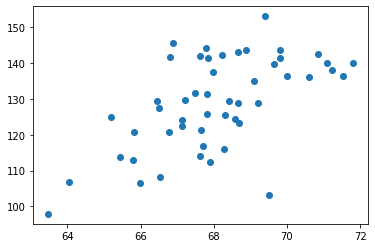

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'o')
plt.show()

### 컬럼 조회 select

컬럼은 아래와 같이 ```select()```로 선택할 수 있다.
컬럼은 그 명칭을 사용하거나 ```myDf.name```, 인덱스 ```myDf['name']```로 선택할 수 있다.

컬럼 선택 | 예제 | 권고
-----|-----|-----
점 연산자로 컬럼을 선택 | myDf.name | N
인덱스로 컬럼을 선택 | myDf['name'] | Y

#### 컬럼명으로 직접 조회 못해

컬럼명만 아래와 같이 적어주어도 조회할 수 없다.

In [54]:
myDf['name']

Column<b'name'>

또는 컬럼 데이터를 조회하기 위해 컬럼에 show(), collect() 함수를 사용해서는 안된다. ```select()```를 사용해서 컬럼을 읽을 수 있다.

In [62]:
myDf['name'].show()

TypeError: 'Column' object is not callable

#### select후 collect

In [63]:
_name=myDf.select('name')
_name.show()

+-------+
|   name|
+-------+
|kim, js|
|lee, sm|
|lim, yg|
|    lee|
+-------+



여러 컬럼을 조회하기 위해서는 해당 컬럼을 넣어주면 된다.

In [64]:
_name=myDf.select('name', 'height').show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



#### select like

In [75]:
myDf.select("name", "height", myDf.name.like("% lee %")).show()

+-------+------+-----------------+
|   name|height|name LIKE % lee %|
+-------+------+-----------------+
|kim, js|   170|            false|
|lee, sm|   175|            false|
|lim, yg|   180|            false|
|    lee|   170|            false|
+-------+------+-----------------+



#### select startswith

In [79]:
myDf.select("name", "height", myDf.name.startswith("kim")).show()

+-------+------+---------------------+
|   name|height|startswith(name, kim)|
+-------+------+---------------------+
|kim, js|   170|                 true|
|lee, sm|   175|                false|
|lim, yg|   180|                false|
|    lee|   170|                false|
+-------+------+---------------------+



#### select endswith

In [80]:
myDf.select("name", "height", myDf.name.endswith("lee")).show()

+-------+------+-------------------+
|   name|height|endswith(name, lee)|
+-------+------+-------------------+
|kim, js|   170|              false|
|lee, sm|   175|              false|
|lim, yg|   180|              false|
|    lee|   170|               true|
+-------+------+-------------------+



### alias

이름을 변경할 경우 alias() 함수를 사용할 수 있다.

DataFrame의 명칭을 변경해보자.

In [20]:
myDf1 = myDf.alias("myDf1")

컬럼의 명칭을 변경해보자.
그러기 위해서는 우선 컬럼을 **```select()```** 함수로 골라낸 후, **```alias```**로 **컬럼명**을 정할 수 있다.
name 컬럼을 **```substr```**으로 1,3문자를 선택한다.

In [27]:
myDf1.select(myDf1.name.substr(1,3).alias("short name")).show(3)

+----------+
|short name|
+----------+
|       kim|
|       lee|
|       lim|
+----------+
only showing top 3 rows



#### 행과 열을 선택 select, when, otherwise

In [70]:
from pyspark.sql.functions import when
myDf.select("height", when(myDf.height < 175, 1).otherwise(0)).show()

+------+------------------------------------------+
|height|CASE WHEN (height < 175) THEN 1 ELSE 0 END|
+------+------------------------------------------+
|   170|                                         1|
|   175|                                         0|
|   180|                                         0|
|   170|                                         1|
+------+------------------------------------------+



alias 명령어로 컬럼을 변경해 줄 수 있다.

In [72]:
from pyspark.sql.functions import when
myDf.select("height", (when(myDf.height < 175, 1).otherwise(0)).alias('<175')).show()

+------+----+
|height|<175|
+------+----+
|   170|   1|
|   175|   0|
|   180|   0|
|   170|   1|
+------+----+



또는 0, 1이 아닌 문자열로 생성할 수 있다.

In [82]:
from pyspark.sql.functions import when
_myDf=myDf.select(when(myDf['heightD'] >175.0, ">175").otherwise("<175").alias("how tall"))

In [83]:
_myDf.show()

+--------+
|how tall|
+--------+
|    <175|
|    <175|
|    >175|
|    <175|
+--------+



withColumn() 함수를 사용하면, DataFrame에 컬럼을 추가하게 된다.

In [84]:
_myDf = myDf.withColumn('how tall', when(myDf['heightD'] >175.0, ">175").otherwise("<175"))
_myDf.show()

+---+----+-------+------+-------+-----+---------+--------+
|_c0|year|   name|height|heightD|yearI|nameUpper|how tall|
+---+----+-------+------+-------+-----+---------+--------+
|  0|   1|kim, js|   170|  170.0|    1|  KIM, JS|    <175|
|  1|   1|lee, sm|   175|  175.0|    1|  LEE, SM|    <175|
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|    >175|
|  3|   2|    lee|   170|  170.0|    2|      LEE|    <175|
+---+----+-------+------+-------+-----+---------+--------+



#### 행과 열을 선택  where, select


DataFrame은 관계형데이터베이스의 테이블과 매우 유사하다. **SQL 명령**을 사용하듯이 ```where()```, ```select()```, ```groupby()``` 함수를 사용할 수 있다.

* 행: ```where()```에 따라 컬럼의 조건에 맞는 행을 선택하고,
* 열: 앞서 배운 ```select()```로 열을 선택

In [65]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+



### filter

```filter()```는 조건에 따라 데이터를 걸러낸다.

In [53]:
myDf.filter(myDf['height'] > 175).show()

+---+----+-------+------+-------+-----+---------+
|_c0|year|   name|height|heightD|yearI|nameUpper|
+---+----+-------+------+-------+-----+---------+
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|
+---+----+-------+------+-------+-----+---------+



### Row의 split (앞 tDf에서 split??)

Row 객체의 값은 아래와 같이 단순하게 split 할 수 없으며, 오류가 발생한다. ```dict```로 변환한 후 그 값을 split해야 한다.

```python
_name.rdd.map(lambda line:[line.split(',')])
```

In [35]:
from pyspark.sql import Row
r=Row(name=u'kim, js')
rd=r.asDict()
print (rd.values().split(','))

AttributeError: 'dict_values' object has no attribute 'split'

### regexp_replace 컬럼의 내용 변경

In [60]:
from pyspark.sql.functions import *

_heightDf = heightDf.withColumn('nameNew', regexp_replace('name', 'lee', 'lim'))
_heightDf.show()

+---+----+-------+------+-------+-----+---------+----------+-------+
|_c0|year|   name|height|heightD|yearI|nameUpper|height>175|nameNew|
+---+----+-------+------+-------+-----+---------+----------+-------+
|  0|   1|kim, js|   170|  170.0|    1|  KIM, JS|   shorter|kim, js|
|  1|   1|lee, sm|   175|  175.0|    1|  LEE, SM|    taller|lim, sm|
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|    taller|lim, yg|
|  3|   2|    lee|   170|  170.0|    2|      LEE|   shorter|    lim|
+---+----+-------+------+-------+-----+---------+----------+-------+



### groupBy

컬럼을 학년에 따라,
```groupBy()```하면 아래와 같이 데이터만 집단화하게 된다.
집단화하면 개수를 세거나, 합계를 내거나 어떤 통계량을 계산이 필요하다.

In [50]:
myDf.groupby(myDf['year'])

#### groupBy하고 max

컬럼을 기준으로 구분지어서 평균, 합계, 갯수, 최대, 최소 등을 구할 수 있다.
첫 컬럼 학년을 ```groupby()```해서 최대값 ```max()```를 구해보자.

In [51]:
myDf.groupby(myDf['year']).max().show()

+----+--------+---------+-----------+------------+----------+
|year|max(_c0)|max(year)|max(height)|max(heightD)|max(yearI)|
+----+--------+---------+-----------+------------+----------+
|   1|       1|        1|        175|       175.0|         1|
|   2|       3|        2|        180|       180.0|         2|
+----+--------+---------+-----------+------------+----------+



#### groupBy, agg

```agg()```는 합계 함수를 계산할 수 있으며, 지원하는 함수는 ```avg, max, min, sum, count```이다.

```year``` 컬럼에 대해 ```agg()``` 함수로 계산할 수 있다.

dictionary 형식으로 key는 컬럼명, value는 합계 함수를 적어준다.
예를 들어 {"heightD":"avg"}에서 "heightD"는 컬럼명, "avg"는 합계함수이다.

In [52]:
myDf.groupBy('year').agg({"heightD":"avg"}).show()

+----+------------+
|year|avg(heightD)|
+----+------------+
|   1|       172.5|
|   2|       175.0|
+----+------------+



#### groupBy 국가별 인원수

월드컵 데이터를 groupBy 해보자.

In [69]:
wcDf.groupBy(wcDf.ClubCountry).count().show()

NameError: name 'wcDf' is not defined

#### groupBy 국가별 포지션별 인원수

wcDf.groupBy('ClubCountry').pivot('Position').count().show()

#### F 함수

또는 아래와 같이 별도 ```pyspark.sql.functions```을 사용할 수 있다.
앞서 pyspark.sql.functions은 함수이므로, ```from pyspark.sql.functions import split``` 이렇게 한다.
또는 ```from pyspark.sql import functions as F```라고 한다.

In [81]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD),F.max(myDf.heightD),F.avg(myDf.heightD),F.sum(myDf.heightD)).show()

+------------+------------+------------+------------+
|min(heightD)|max(heightD)|avg(heightD)|sum(heightD)|
+------------+------------+------------+------------+
|       170.0|       180.0|      173.75|       695.0|
+------------+------------+------------+------------+



### partition

#### partition 개수

In [15]:
myDf.rdd.getNumPartitions()

1

#### repartition

repartition()은 partition의 개수를 늘리거나 줄이거나 재설정한다.

In [10]:
_myDf = myDf.repartition(4)
print(_myDf.rdd.getNumPartitions())

4


#### coalesce

coalesce()는 partition을 줄일 때 사용한다.
앞서 4개의 partition을 가진 ```_myDf```를 2로 줄여보자.

In [17]:
_myDf2 = _myDf.coalesce(2)
print(_myDf2.rdd.getNumPartitions())

2


### 통계 요약 describe

column이 연산가능한 데이터타잎인 경우, 요약 값을 볼 수 있다.

In [93]:
myDf.describe().show()

+-------+------------------+------------------+------------------+
|summary|            height|           heightD|             yearI|
+-------+------------------+------------------+------------------+
|  count|                 4|                 4|                 4|
|   mean|            173.75|            173.75|               1.5|
| stddev|4.7871355387816905|4.7871355387816905|0.5773502691896257|
|    min|               170|             170.0|                 1|
|    max|               180|             180.0|                 2|
+-------+------------------+------------------+------------------+



### 결측값

* Replacing null values
dataframe.na.fill()
dataFrame.fillna()
dataFrameNaFunctions.fill()
* Returning new dataframe restricting rows with null valuesdataframe.na.drop()
dataFrame.dropna()
dataFrameNaFunctions.drop()
* Return new dataframe replacing one value with another
dataframe.na.replace(5, 15)
dataFrame.replace()
dataFrameNaFunctions.replace()

In [86]:
from pyspark.sql import functions as F
myDf.where(F.col("height").isNull())

DataFrame[_c0: int, year: int, name: string, height: int, heightD: double, yearI: int, nameUpper: string]

In [87]:
from pyspark.sql.functions import isnan, when, count, col
myDf.select([count(when(isnan(c), c)).alias(c) for c in myDf.columns]).show()

+---+----+----+------+-------+-----+---------+
|_c0|year|name|height|heightD|yearI|nameUpper|
+---+----+----+------+-------+-----+---------+
|  0|   0|   0|     0|      0|    0|        0|
+---+----+----+------+-------+-----+---------+



In [88]:
from pyspark.sql.functions import isnan, when, count, col
myDf.select([count(when(col(c).isNull(), c)).alias(c) for c in myDf.columns]).show()

+---+----+----+------+-------+-----+---------+
|_c0|year|name|height|heightD|yearI|nameUpper|
+---+----+----+------+-------+-----+---------+
|  0|   0|   0|     0|      0|    0|        0|
+---+----+----+------+-------+-----+---------+



## 문제: 년별 분기별 대여건수

서울시 열린데이터 https://data.seoul.go.kr/ 서울시 공공자전거 이용현황 데이터를 분석해보자.

## S.6 Spark SQL

DataFrame을 관계형 데이터베이스에서 우리가 사용하는 Sql을 사용할 수 있다. RDD는 비구조적인 경우에 사용하므로 테이블로 변환한 후 Sql을 사용하게 된다.

* Spark SQL 구성

구분 | 설명
-----|-----
Language API | Python, Java, Scala, Hive QL API를 제공
Schema RDD | RDD에 Schema를 적용해 임시 테이블로 변환한다.<br>createOrReplaceTempView<br>createGlobalTempView
Data Sources | 다양한 형식 지원 - HDFS, Cassandra, HBase, RDB

앞서 만들어 놓은 World Cup 데이터를 사용한다.

In [244]:
wcDf.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)



이제 임시 테이블 ```wc```를 만들고, Sql문으로 데이터를 조회해보자.

In [245]:
wcDf.createOrReplaceTempView("wc")
spark.sql("select Club,Team,Year from wc").show(1)

+--------------------+---------+----+
|                Club|     Team|Year|
+--------------------+---------+----+
|Club AtlÃ©tico Ta...|Argentina|1930|
+--------------------+---------+----+
only showing top 1 row



In [246]:
wcPlayers=spark.sql("select FullName,Club,Team,Year from wc")
wcPlayers.show(1)

+------------+--------------------+---------+----+
|    FullName|                Club|     Team|Year|
+------------+--------------------+---------+----+
|Ãngel Bossio|Club AtlÃ©tico Ta...|Argentina|1930|
+------------+--------------------+---------+----+
only showing top 1 row



In [247]:
spark.catalog.listTables()

[Table(name='wc', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

```wcPlayers```를 RDD로 변환해서 이름만 출력해 보자.

In [249]:
namesRdd=wcPlayers.rdd.map(lambda x: "Full name: "+x[0])
for e in namesRdd.take(5):
    print (e)

Full name: Ãngel Bossio
Full name: Juan Botasso
Full name: Roberto Cherro
Full name: Alberto Chividini
Full name: 


#### sql.functions and join

리스트에 포함되어 있는 과일에 고유번호를 할당해 보자.

In [79]:
bucketDf=spark.createDataFrame([[1,["orange", "apple", "pineapple"]],
                                [2,["watermelon","apple","bananas"]]],
                               ["bucketId","items"])

In [80]:
bucketDf.show(truncate=False)

+--------+----------------------------+
|bucketId|items                       |
+--------+----------------------------+
|1       |[orange, apple, pineapple]  |
|2       |[watermelon, apple, bananas]|
+--------+----------------------------+



* explode

컬럼에 List 또는 배열이 포함된 경우 ```explode()``` 함수는 이를 flat해서 새로운 컬럼을 생성하게 된다.


In [82]:
from pyspark.sql.functions import explode
bDf=bucketDf.select(bucketDf.bucketId, explode(bucketDf.items).alias('item'))

In [83]:
bDf.show()

+--------+----------+
|bucketId|      item|
+--------+----------+
|       1|    orange|
|       1|     apple|
|       1| pineapple|
|       2|watermelon|
|       2|     apple|
|       2|   bananas|
+--------+----------+



또 다른 DataFrame을 생성해보자. 나중에 앞의 DataFrame과 join하게 된다.

In [96]:
fDf=spark.createDataFrame([["orange", "F1"],
                            ["", "F2"],
                            ["pineapple","F3"],
                            ["watermelon","F4"],
                            ["bananas","F5"]],
                            ["item","itemId"])

In [100]:
fDf.show()

+----------+------+
|      item|itemId|
+----------+------+
|    orange|    F1|
|          |    F2|
| pineapple|    F3|
|watermelon|    F4|
|   bananas|    F5|
+----------+------+



* join

join은 ```inner, cross, outer, full, full_outer, left, left_outer, right, right_outer, left_semi, left_anti``` 여러 종류가 있다. ```inner```기준으로 item이 일치하지 않는 것은 제외하게 된다.

In [98]:
joinDf=fDf.join(bDf, fDf.item==bDf.item, "inner")

In [99]:
joinDf.select(fDf.itemId,fDf.item,bDf.bucketId).show()

+------+----------+--------+
|itemId|      item|bucketId|
+------+----------+--------+
|    F5|   bananas|       2|
|    F1|    orange|       1|
|    F3| pineapple|       1|
|    F4|watermelon|       2|
+------+----------+--------+



## 문제 S-1: 네트워크에 불법적으로 침입하는 사용자의 분석

### 문제

네트워크에 불법적으로 침입하는 시도는 허용되어서는 안된다.
1998년 MIT Lincoln Labs에서 DARPA Intrusion Detection Evaluation Program을 연구하였다.
이 데이터의 일부가 1999년 KDD로 만들어져 배포되고 있다.
https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

### 해결

마지막 행에 attack의 유형이 구분되어 있다. 네트워크 침입 유형의 특징을 분석해 보자.
탐지예방 모델을 구축할 수 있다.


## 문제 S-2: Twitter JSON 데이터 읽기

* [nok] 현재 디렉토리 _tweet.json
    * src/ds_twitter_3.py로 변경 (ds_twitter_3.json으로 저장)



* Twitter JSON을 읽을 경우

구분 | 예
-------|-------
unicode를 사용하면 backslash | "{\"created_at\":\"Sun Nov 13 00:05:19 +0000 2016\"
보통 | {"created_at":"Sun Nov 13 00:05:19 +0000 2016"

* allowBackslashEscapingAnyCharacter

## 문제 S-3: 뉴욕에서 출생한 신생아 분석

### 뉴욕에서 출생한 신생아가 년도별 성별에 차이가 있을까?

뉴욕에서 2007년 출생한 유아의 기록이다.
https://health.data.ny.gov/Health/Baby-Names-Beginning-2007/jxy9-yhdk

Column Name | 설명
-----|-----
Year | Year data was collected.
First Name | 이름
County | Location where the baby’s mother resided as stated on their birth certificate.
Sex | F= Female M= Male
Count | Five (5) or more of the same baby name in a county outside of NYC; Ten (10) or more of the same baby name in a NYC borough.


## 문제 S-4: 우버 택시의 운행기록 분석

* 질문: 2015년 가장 많은 운행을 한 base는?
https://github.com/tmcgrath/spark-with-python-course/blob/master/Spark-SQL-CSV-with-Python.ipynb

* fivethirtyeight
    * git clone https://github.com/fivethirtyeight/uber-tlc-foil-response.git
        daily Uber trip statistics in January and February 2015

dispatching_base_number | date | active_vehicles | trips
----------|----------|----------|----------
B02512 | 1/1/2015 | 190 | 1132
B02765 | 1/1/2015 | 225 | 1765


## 문제 S-5: JDBC를 사용해서 데이터 읽기

* jdbc를 연결하는 방식은 Java와 같이 'driver', 'url'을 설정하면 된다.
* 여기서는 sqlite를 실습한다.

* sqlite와 같이 Spark 패키지가 없는 경우, jar를 다운로드하고
설정파일 conf/spark-defaults.conf에 'spark.driver.extraClassPath'를 추가한다.


## S.7 MongoDB Spark connector

* Spark에서 MongoDB에 저장된 데이터를 읽어 온다.
* 참조: pymongo-spark (Spark와 PyMongo를 사용하는 Python 라이브러리, 설치하려면 pip install pymongo-spark)


### S.7.1 설정

* 참조 https://docs.mongodb.com/spark-connector/
* 설정파일 conf/spark-defaults.conf 수정
    * Spark 버전에 맞는 jar를 선택한다.
    * MongoDB<3.2인 경우, spark.mongodb.input.partitioner가 필요하다.
    * packages 여러 개를 넣을 경우에는 컴마로 분리한다.

```python
$vim conf/spark-defaults.conf 
spark.jars.packages=org.mongodb.spark:mongo-spark-connector_2.10:1.1.0
spark.mongodb.input.partitioner=MongoPaginateBySizePartitioner
```

In [32]:
print spark.conf.get('spark.jars.packages')

graphframes:graphframes:0.4.0-spark2.0-s_2.11,org.mongodb.spark:mongo-spark-connector_2.10:2.0.0,com.databricks:spark-csv_2.11:1.5.0


## S.8 spark-submit

* spark-submit는 일괄실행 (self-contained app in quick-start 참조)

* MongoDB를 사용하려면, spark-defaults.conf에 jar를 추가한다 (앞서 미리 설정하였다.)

* spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하였다.
```python
log4j.rootCategory=ERROR, console
```

### S.8.1 간단한 작업

* DataFrame 만들고, 출력하기


In [42]:
%%writefile src/ds_spark_sql.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark

def doIt():
    d = [{'name': 'Alice', 'age': 1}]
    print spark.createDataFrame(d).collect()

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_sql.py


In [44]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_sql.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent